In [554]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import acquire_r
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk
from sklearn.neighbors import KNeighborsClassifier

In [97]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [315]:
# List of urls to scrape
g_url = ['https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=forks&type=Repositories', ' https://github.com/search?o=desc&p=2&q=stars%3A%3E1&s=forks&type=Repositories'\
         'https://github.com/search?o=desc&p=3&q=stars%3A%3E1&s=forks&type=Repositories', 'https://github.com/search?o=desc&p=4&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=5&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=6&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=7&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=8&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=9&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=10&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=11&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=12&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=13&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=14&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=15&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=16&q=stars%3A%3E1&s=forks&type=Repositories',
        'https://github.com/search?o=desc&p=17&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=18&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=19&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=20&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=21&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=22&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=23&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=24&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=25&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=26&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=27&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=28&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=29&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=30&q=stars%3A%3E1&s=forks&type=Repositories']

In [316]:
def get_repos(urls):
    repo = []
    for url in urls:
        time.sleep(10)
        response = get(url, headers=headers)
        soup = BeautifulSoup(response.text)
        text = soup.find_all(attrs={"f4 text-normal"})
        for i in text:
            repo.append(i.find('a')['href'])
    return repo

In [317]:
repos = get_repos(g_url)

In [323]:
# list = []
# for repo in repos:
#     list.append(repo[1:])
    

In [92]:
#repos = scraper.get_repos(g_url)

/Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py:28: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 28 of the file /Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [495]:
f = open('data2.json')
json_file = json.load(f)

In [496]:
df = pd.DataFrame(json_file)

In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             280 non-null    object
 1   language         245 non-null    object
 2   readme_contents  280 non-null    object
dtypes: object(3)
memory usage: 6.7+ KB


In [500]:
df.isnull().sum()

repo                0
language           35
readme_contents     0
dtype: int64

In [501]:
df = df.dropna(axis =0)

In [502]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 1 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             245 non-null    object
 1   language         245 non-null    object
 2   readme_contents  245 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


In [503]:
df = df.reset_index(drop = True)

In [504]:
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
HTML                12
Jupyter Notebook    12
Go                  11
PHP                 11
TypeScript          10
Ruby                 9
C                    8
CSS                  8
Shell                5
Vue                  3
C#                   2
Kotlin               2
R                    2
Rust                 2
TeX                  2
PowerShell           2
Swift                1
ApacheConf           1
Dart                 1
Scala                1
Objective-C          1
Groovy               1
Name: language, dtype: int64

In [505]:
df['language'] = df.language.replace(['PHP','Shell','Kotlin','Vue','ApacheConf','Jupyter Notebook','R','Groovy',\
                                      'Kotlin','Scala','Rust', 'Swift','C#','Dart','Ruby','Objective-C','PowerShell','TeX' ], 'Other')

In [506]:
df = df[df.language != 'Other']

In [507]:
df.language.value_counts()

JavaScript    58
Java          33
Python        31
C++           16
HTML          12
Go            11
TypeScript    10
CSS            8
C              8
Name: language, dtype: int64

In [508]:
df['language'] = df.language.replace(['C', 'CSS', 'TypeScript', 'Go' ], 'Other')

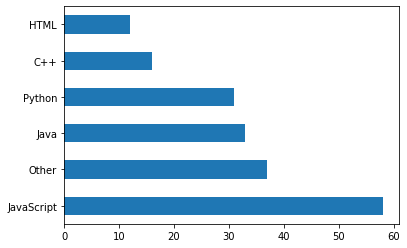

In [509]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh()

In [510]:
df = df.drop(columns = ['repo'])

In [511]:
df.head(4)

,language,readme_contents
1,HTML,### Well hello there!\n\nThis repository is me...
2,C++,"<div align=""center"">\n <img src=""https://www...."
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
5,Python,![Logo](https://storage.googleapis.com/model_g...


In [512]:
df = prepare_r.prep_contents(df)

In [513]:
df = df.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])
df.head(4)

,language,readme_contents,cleaned
1,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...
2,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src tensorflow org image ...
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...
5,Python,![Logo](https://storage.googleapis.com/model_g...,logo storage googleapis com model garden artif...


In [514]:
# Train/test split before exploration
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

## Exploration
***

In [515]:
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com               6843
org               1650
img               1052
doc               1043
python             990
svg                947
data               919
html               826
src                825
api                767
opencollective     762
master             759
javascript         742
webpack            733
build              729
dtype: int64

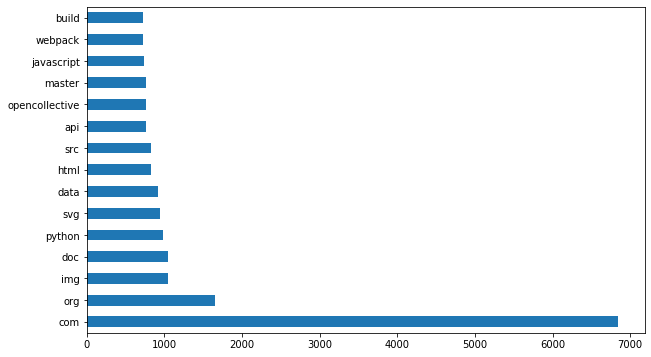

In [516]:
plt.figure(figsize = (10,6))
word_counts.plot.barh()

In [517]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in train.cleaned if word in doc])
    return len(train.cleaned) / n_occurences

In [518]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['align', 'center', 'href', ..., 'dehaan', 'mpdehaan', 'redhat'],
      dtype=object)

In [519]:
# put the unique words into a data frame
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

In [520]:
idf_train.head(10)

,idf
word,
drjekyllthemes,149.0
alykhan,149.0
antiga,149.0
alban,149.0
desmaison,149.0
koepf,149.0
bradbury,149.0
zeming,149.0
yuandong,149.0


Text(0.5, 0, 'IDF value')

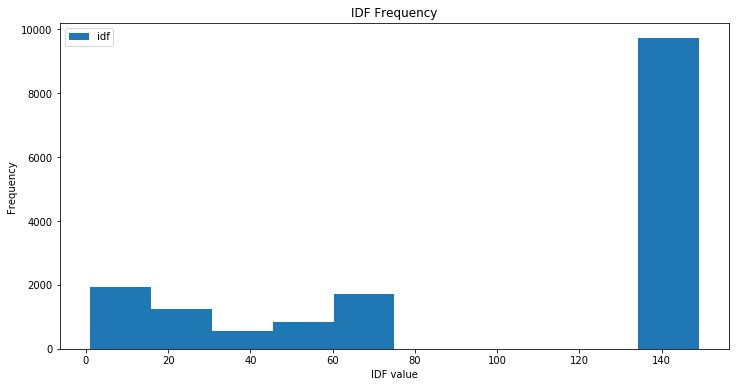

In [521]:
idf_train.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')


In [522]:
# here we create a new column with number of words for each readme file.
train['readme_words'] = train['cleaned'].apply(lambda x: len(x.split()))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [523]:
train

,language,readme_contents,cleaned,readme_words
159,JavaScript,"<p align=""center"">\n <a href=""https://reacttr...",align center href reacttraining com react rout...,480
244,C++,# Tesseract OCR\n\n[![Build Status](https://tr...,tesseract ocr build status travis org tesserac...,782
127,HTML,# learning-area\nGithub repo for the [MDN Lear...,learning area repo mdn learning area developer...,53
55,Other,"# Visual Studio Code - Open Source (""Code - OS...",visual studio code open source code os build s...,519
167,Java,OkHttp\n======\n\nSee the [project website][ok...,okhttp see project website okhttp documentatio...,519
...,...,...,...,...
201,Java,# RxJava: Reactive Extensions for the JVM\n\n<...,rxjava reactive extension jvm href travis org ...,2699
211,Other,FFmpeg README\n=============\n\nFFmpeg is a co...,ffmpeg readme ffmpeg collection library tool p...,163
106,Java,![LeetCode Animation All in One](https://uploa...,leetcode animation one upload image jianshu up...,986
143,Python,======\nScrapy\n======\n\n.. image:: https://i...,scrapy image img shield pypi scrapy svg target...,244


(0, 10000)

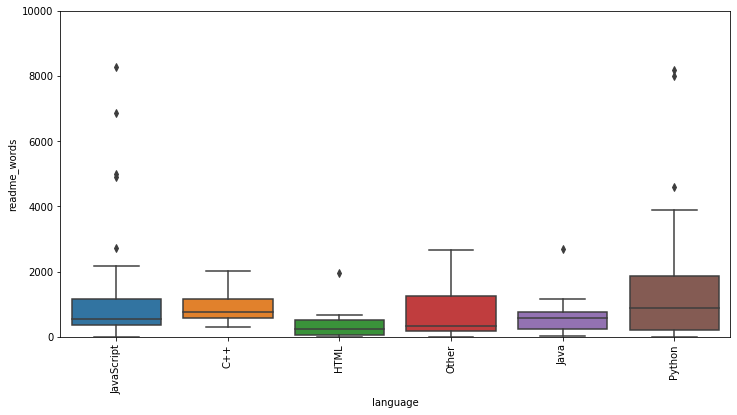

In [524]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,10000)

(0, 2000)

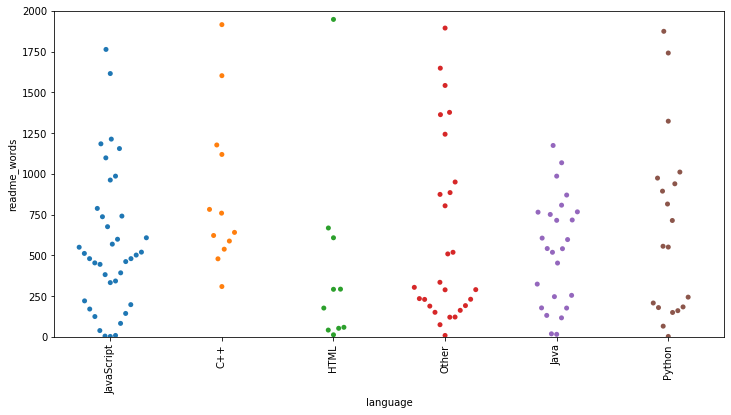

In [525]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,2000)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread

In [526]:
# Next lets explore which words appear most often in a particular language
train.language.value_counts()

JavaScript    46
Other         29
Java          26
Python        25
C++           13
HTML          10
Name: language, dtype: int64

In [527]:
All_words = pd.Series(' '.join(train.cleaned).split()).value_counts()
JavaScript_words = pd.Series(' '.join(train[train.language == 'JavaScript'].cleaned).split()).value_counts()
Other_words = pd.Series(' '.join(train[train.language == 'Other'].cleaned).split()).value_counts()
Python_words = pd.Series(' '.join(train[train.language == 'Python'].cleaned).split()).value_counts()
java_words = pd.Series(' '.join(train[train.language == 'Java'].cleaned).split()).value_counts()
TypeScript_words = pd.Series(' '.join(train[train.language == 'TypeScript'].cleaned).split()).value_counts()
Cplus_words = pd.Series(' '.join(train[train.language == 'C++'].cleaned).split()).value_counts()
CSS_words = pd.Series(' '.join(train[train.language == 'CSS'].cleaned).split()).value_counts()
HTML_words = pd.Series(' '.join(train[train.language == 'HTML'].cleaned).split()).value_counts()
C_words = pd.Series(' '.join(train[train.language == 'C'].cleaned).split()).value_counts()
Go_words = pd.Series(' '.join(train[train.language == 'Go'].cleaned).split()).value_counts()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to 

In [528]:
word_counts = (pd.concat([All_words, JavaScript_words, Other_words, Python_words,java_words, TypeScript_words, Cplus_words,\
                         CSS_words,HTML_words, C_words, Go_words],\
                         axis=1, sort=True).set_axis(['All','JavaScript', 'Other', 'Python','Java', 'TypeScript', 'C++',\
                         'CSS','HTML', 'C', 'Go_'], axis=1, inplace=False).fillna(0)\
               .apply(lambda s: s.astype(int)))

word_counts.head()

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
aaaaaaaaaac,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaaai,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaad,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaecm,1,1,0,0,0,0,0,0,0,0,0
aaaaaaaaerc,1,1,0,0,0,0,0,0,0,0,0


In [529]:
word_counts.sort_values(by='All', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,6843,2093,612,2950,582,0,480,0,126,0,0
org,1650,492,174,546,131,0,280,0,27,0,0
img,1052,681,107,89,127,0,39,0,9,0,0
doc,1043,307,113,284,231,0,95,0,13,0,0
python,990,2,2,923,5,0,57,0,1,0,0
svg,947,615,121,72,71,0,64,0,4,0,0
data,919,202,51,596,52,0,14,0,4,0,0
html,826,305,49,276,84,0,79,0,33,0,0
src,825,679,27,30,57,0,28,0,4,0,0
api,767,207,34,436,49,0,40,0,1,0,0


In [530]:
word_counts.sort_values(by='JavaScript', ascending=False)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,6843,2093,612,2950,582,0,480,0,126,0,0
opencollective,762,713,8,1,14,0,26,0,0,0,0
webpack,733,713,20,0,0,0,0,0,0,0,0
img,1052,681,107,89,127,0,39,0,9,0,0
src,825,679,27,30,57,0,28,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
mist,6,0,0,6,0,0,0,0,0,0,0
deed,1,0,0,1,0,0,0,0,0,0,0
misterbigbooo,1,0,0,0,1,0,0,0,0,0,0
misterbooo,1,0,0,0,1,0,0,0,0,0,0


Text(0.5, 1.0, 'Word cloud for all words')

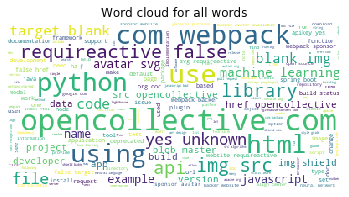

In [531]:
# word cloud for all words
img = WordCloud(background_color='white').generate(' '.join(train.cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Word cloud for all words')

Text(0.5, 1.0, 'Python wordcloud')

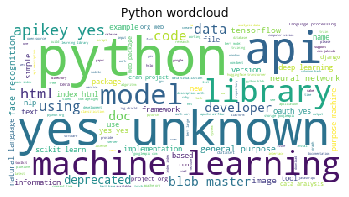

In [532]:
# word cloud for Python
img = WordCloud(background_color='white').generate(' '.join(train[train.language == 'Python'].cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python wordcloud')

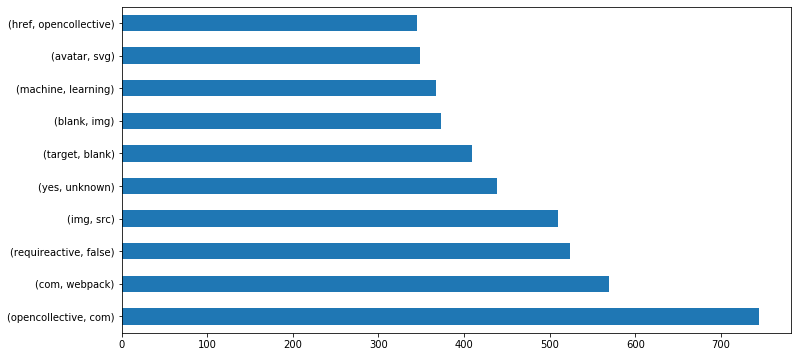

In [533]:
#lets look at bigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 2)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [534]:
top_30_bigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 2)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Bigrams')

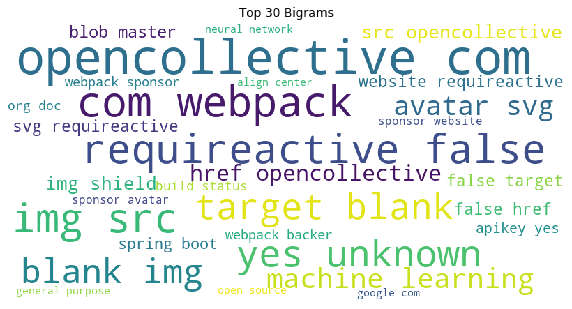

In [535]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Bigrams')

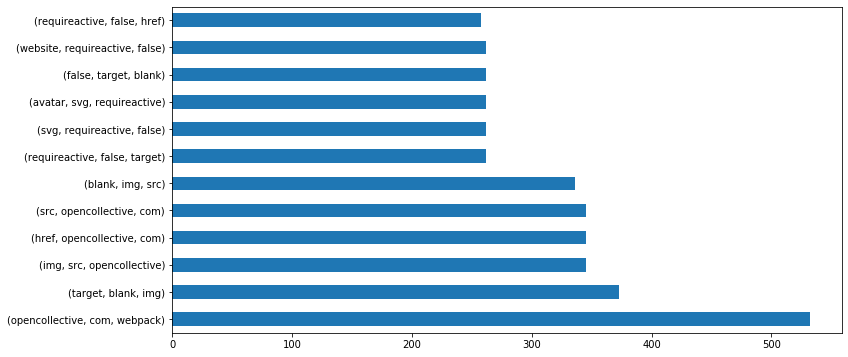

In [536]:
#lets look at trigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 3)
pd.Series(bigrams).value_counts().head(12).plot.barh()

In [537]:
top_30_trigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 3)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Trigrams')

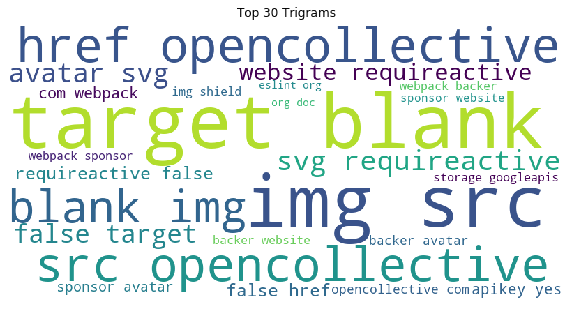

In [538]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Trigrams')

In [539]:
def digits(text):
    digits = len(re.sub("[^0-9]", "", text ))
    return digits    

In [540]:
train['digits'] = train.readme_contents.apply(digits)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [541]:
train

,language,readme_contents,cleaned,readme_words,digits
159,JavaScript,"<p align=""center"">\n <a href=""https://reacttr...",align center href reacttraining com react rout...,480,94
244,C++,# Tesseract OCR\n\n[![Build Status](https://tr...,tesseract ocr build status travis org tesserac...,782,118
127,HTML,# learning-area\nGithub repo for the [MDN Lear...,learning area repo mdn learning area developer...,53,0
55,Other,"# Visual Studio Code - Open Source (""Code - OS...",visual studio code open source code os build s...,519,56
167,Java,OkHttp\n======\n\nSee the [project website][ok...,okhttp see project website okhttp documentatio...,519,73
...,...,...,...,...,...
201,Java,# RxJava: Reactive Extensions for the JVM\n\n<...,rxjava reactive extension jvm href travis org ...,2699,228
211,Other,FFmpeg README\n=============\n\nFFmpeg is a co...,ffmpeg readme ffmpeg collection library tool p...,163,0
106,Java,![LeetCode Animation All in One](https://uploa...,leetcode animation one upload image jianshu up...,986,3339
143,Python,======\nScrapy\n======\n\n.. image:: https://i...,scrapy image img shield pypi scrapy svg target...,244,3


(0, 500)

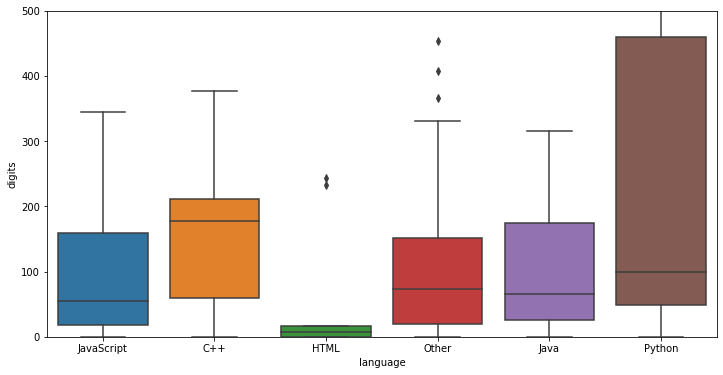

In [542]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'digits', data = train)
plt.ylim(0,500)

## Modeling

In [543]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [544]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [545]:
X_train

<149x21152 sparse matrix of type '<class 'numpy.float64'>'
	with 49501 stored elements in Compressed Sparse Row format>

In [546]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [547]:
lm = LogisticRegression(solver = 'liblinear', C = 2).fit(X_train, y_train)
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [548]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.32%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++          12     0     0           0      0       0
HTML          0     7     0           0      0       0
Java          0     0    26           0      0       0
JavaScript    1     2     0          46      0       0
Other         0     1     0           0     29       0
Python        0     0     0           0      0      25
---
              precision    recall  f1-score   support

         C++       1.00      0.92      0.96        13
        HTML       1.00      0.70      0.82        10
        Java       1.00      1.00      1.00        26
  JavaScript       0.94      1.00      0.97        46
       Other       0.97      1.00      0.98        29
      Python       1.00      1.00      1.00        25

    accuracy                           0.97       149
   macro avg       0.98      0.94      0.96       149
weighted avg       0.97      0

In [549]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 44.74%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
Java          0     0     5           0      0       0
JavaScript    3     2     2          12      7       6
Python        0     0     0           0      1       0
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       1.00      0.71      0.83         7
  JavaScript       0.38      1.00      0.55        12
       Other       0.00      0.00      0.00         8
      Python       0.00      0.00      0.00         6

    accuracy                           0.45        38
   macro avg       0.23      0.29      0.23        38
weighted avg       0.30      0.45      0.33        38



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [550]:
from sklearn.tree import DecisionTreeClassifier
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [551]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 66.44%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           8     0     0           0      0       0
Java          0     2    19           1      1       1
JavaScript    1     0     0          32      5       0
Other         4     8     7          13     23       7
Python        0     0     0           0      0      17
---
              precision    recall  f1-score   support

         C++       1.00      0.62      0.76        13
        HTML       0.00      0.00      0.00        10
        Java       0.79      0.73      0.76        26
  JavaScript       0.84      0.70      0.76        46
       Other       0.37      0.79      0.51        29
      Python       1.00      0.68      0.81        25

    accuracy                           0.66       149
   macro avg       0.67      0.59      0.60       149
weighted avg       0.73      0.66      0.67       149



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [552]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 52.63%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Other  Python
predicted                                             
C++           0     0     0           0      1       0
Java          1     0     4           0      1       0
JavaScript    0     0     0           4      0       0
Other         2     2     3           7      6       0
Python        0     0     0           1      0       6
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.67      0.57      0.62         7
  JavaScript       1.00      0.33      0.50        12
       Other       0.30      0.75      0.43         8
      Python       0.86      1.00      0.92         6

    accuracy                           0.53        38
   macro avg       0.47      0.44      0.41        38
weighted avg       0.64      0.53      0.51        38



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [566]:
knn = KNeighborsClassifier(n_neighbors=8, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)


In [567]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         C++       1.00      0.23      0.38        13
        HTML       0.60      0.30      0.40        10
        Java       0.83      0.73      0.78        26
  JavaScript       0.62      0.91      0.74        46
       Other       0.71      0.17      0.28        29
      Python       0.53      0.92      0.68        25

    accuracy                           0.64       149
   macro avg       0.72      0.54      0.54       149
weighted avg       0.69      0.64      0.59       149



In [568]:
y_pred_test = knn.predict(X_test)
y_pred_test

array(['Python', 'JavaScript', 'Java', 'JavaScript', 'JavaScript',
       'JavaScript', 'Java', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'Java',
       'Python', 'JavaScript', 'JavaScript', 'Other', 'JavaScript',
       'Python', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'Java', 'Python', 'HTML', 'Python', 'Python', 'Java',
       'JavaScript'], dtype=object)

In [569]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       1.00      0.50      0.67         2
        Java       1.00      0.71      0.83         7
  JavaScript       0.52      0.92      0.67        12
       Other       1.00      0.12      0.22         8
      Python       0.50      0.83      0.62         6

    accuracy                           0.61        38
   macro avg       0.67      0.51      0.50        38
weighted avg       0.69      0.61      0.54        38



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
